<a href="https://colab.research.google.com/github/psfleury/Data_Science_Projects/blob/main/TCC_Pos_ASPS_v2_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importar as bibliotecas necessárias à análise. Em suma: pandas, numpy, matplotlib, nltk, sklearn (diversos) e random
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('rslp')
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, tree, neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from random import seed

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


In [2]:
# Importar o dataset a ser utilizado, com as dimensões de interesse
col_list = ['dt_AnoEmpenho','cd_Ugestora','de_TipoRecursos','de_Historico', 'tp_Operacao'] 
df = pd.read_csv('https://raw.githubusercontent.com/psfleury/Data_Science_Projects/main/3%20-%20ASPS/Empenhos_ASPS_2012_a_2018.txt', sep='|', usecols=col_list)

In [3]:
# Avaliar a quantidade de linhas (empenhos) e colunas (atributos) da base "crua"
df.shape

(53255, 5)

In [4]:
df.drop_duplicates(inplace=True)

In [5]:
df.shape

(36623, 5)

In [6]:
df.head()

,cd_Ugestora,de_TipoRecursos,tp_Operacao,dt_AnoEmpenho,de_Historico
1,201039,Receita de Impostos e de Transferência de Impo...,E,2017,aquisição de pilhas para a Secretaria de Saúd...
2,201039,Receita de Impostos e de Transferência de Impo...,E,2017,"guias de recolhimento do INSS empresa (Saude),..."
3,201039,Receita de Impostos e de Transferência de Impo...,E,2017,"guias de recolhimento do INSS empresa (saúde),..."
4,201039,Receita de Impostos e de Transferência de Impo...,E,2017,ajuda financeira para tratamento de saúde do ...
5,201039,Receita de Impostos e de Transferência de Impo...,E,2017,ajuda financeira para tratamento de saúde do f...


In [7]:
# Avaliar a quantidade absoluta e o percentual de valores nulos dos campos do dataset
print(df.isnull().sum().sort_values(ascending=False))
print((df.isnull().sum() * 100  / df.shape[0]).sort_values(ascending=False))

de_Historico       3
dt_AnoEmpenho      0
tp_Operacao        0
de_TipoRecursos    0
cd_Ugestora        0
dtype: int64
de_Historico       0.008192
dt_AnoEmpenho      0.000000
tp_Operacao        0.000000
de_TipoRecursos    0.000000
cd_Ugestora        0.000000
dtype: float64


In [8]:
# Excluir registros com descrição NaN na base
df.dropna(inplace=True)

In [9]:
# Confirmando que apenas 3 registros foram excluídos
df.shape

(36620, 5)

In [10]:
# Converter a descrição de empenhos em caixa baixa
df['de_Historico'] = df['de_Historico'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [11]:
# Retirar as stopwords da descrição dos empenhos
stop = stopwords.words('portuguese')
df['de_Historico'] = df['de_Historico'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [12]:
# Retirar prefixos e sufixos, de maneira a manter somente os radicais significativos
stemmer = nltk.stem.RSLPStemmer()
df['de_Historico'] = df['de_Historico'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))

In [13]:
# Transformar variáveis categóricas em tipo "category"
df["cd_Ugestora"] = df["cd_Ugestora"].astype("category")
df["de_TipoRecursos"] = df["de_TipoRecursos"].astype("category")
df["dt_AnoEmpenho"] = df["dt_AnoEmpenho"].astype("category")

In [14]:
# Separar dataset em bases de treino (train) e teste (valid) 
# mantendo proporção dos labels (estratify) e com uma seed aleatoriamente escolhida
features = df[["cd_Ugestora","de_TipoRecursos","dt_AnoEmpenho","de_Historico"]]
label = df['tp_Operacao']
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(features, label, random_state=857, stratify=label)

In [15]:
# dimensões dos dataframes gerados com o train_test_split
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(27465, 4)
(27465,)
(9155, 4)
(9155,)


In [16]:
# Parametrizando o pré-processamento das features
text_features = "de_Historico"
text_transformer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)

categorical_features = ["cd_Ugestora","de_TipoRecursos","dt_AnoEmpenho"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("text column", text_transformer, text_features),
        ("categorical columns", categorical_transformer, categorical_features),
    ]
)

In [17]:
# Cria função que cria pipeline o qual:
# 1) Transforma as features de acordo com a parametrização feita no "preprocessor"
# 2) Ajusta o modelo aos dados de treino (x_train, y_train)
# 3) Realiza predições e avalia tais predições

def train_model(classifier, feature_vector_train, label, feature_vector_valid, label_valid, is_neural_net=False):
  clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", classifier)])
  clf.fit(feature_vector_train, label)
  pred_test = clf.predict(feature_vector_valid)
  conf_mat = confusion_matrix(label_valid, pred_test)
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=["E", "I"], yticklabels=["E", "I"])
  plt.ylabel('Rótulo real')
  plt.xlabel('Rótulo previsto pelo modelo')
  plt.gcf().set_size_inches(8, 6)
  plt.show()
  print(classification_report(label_valid, pred_test, digits=6))
  print("Coeficiente de Matthew: %.6f" % matthews_corrcoef(y_valid, pred_test))

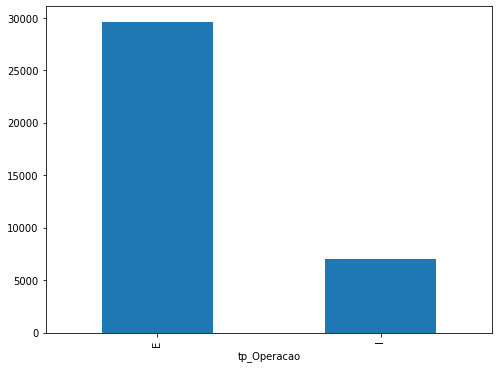

In [18]:
# Composição das classes no dataset total
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('tp_Operacao').de_Historico.count().plot.bar(ylim=0)
plt.show()

Serão treinados os seguintes modelos para a classificação binária em questão:
*   Naive Bayes;
*   K Nearest Neighbors;
*   Regressão logística;
*   Support Vector Machine;
*   Decision Tree;
*   Random Forest.

Por fim, ressalta-se que a matriz de confusão gerada para cada modelo terá a seguinte configuração:
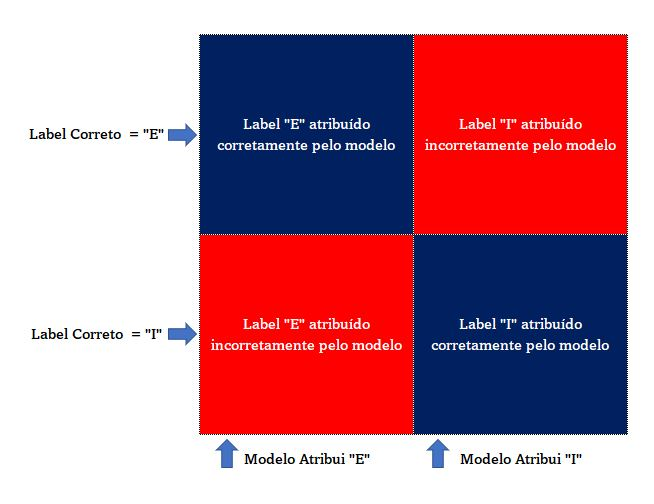



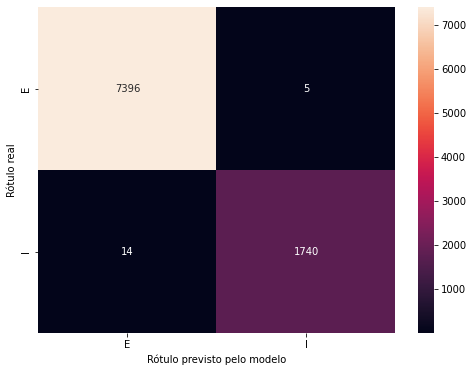

              precision    recall  f1-score   support

           E   0.998111  0.999324  0.998717      7401
           I   0.997135  0.992018  0.994570      1754

    accuracy                       0.997925      9155
   macro avg   0.997623  0.995671  0.996644      9155
weighted avg   0.997924  0.997925  0.997923      9155

Coeficiente de Matthew: 0.993292


In [19]:
# Aplicação do modelo de regressão logística
train_model(linear_model.LogisticRegression(), x_train, y_train, x_valid, y_valid)

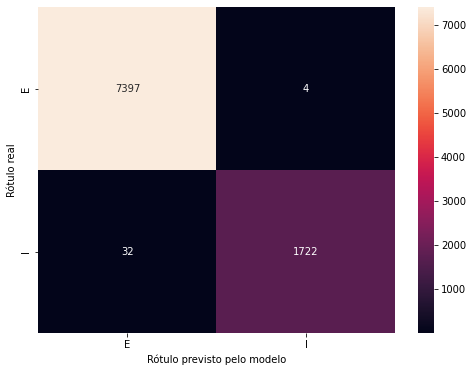

              precision    recall  f1-score   support

           E   0.995693  0.999460  0.997572      7401
           I   0.997683  0.981756  0.989655      1754

    accuracy                       0.996068      9155
   macro avg   0.996688  0.990608  0.993614      9155
weighted avg   0.996074  0.996068  0.996056      9155

Coeficiente de Matthew: 0.987277


In [21]:
# Aplicação do modelo naive bayes
train_model(naive_bayes.MultinomialNB(), x_train, y_train, x_valid, y_valid)

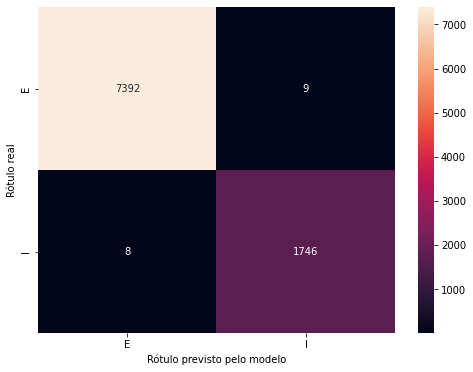

              precision    recall  f1-score   support

           E   0.998919  0.998784  0.998851      7401
           I   0.994872  0.995439  0.995155      1754

    accuracy                       0.998143      9155
   macro avg   0.996895  0.997111  0.997003      9155
weighted avg   0.998144  0.998143  0.998143      9155

Coeficiente de Matthew: 0.994007


In [20]:
# Aplicação do modelo knn
train_model(neighbors.KNeighborsClassifier(), x_train, y_train, x_valid, y_valid)

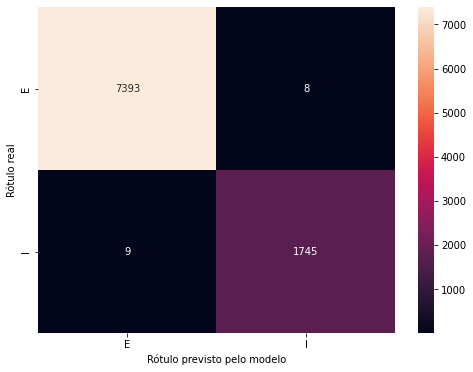

              precision    recall  f1-score   support

           E   0.998784  0.998919  0.998852      7401
           I   0.995436  0.994869  0.995153      1754

    accuracy                       0.998143      9155
   macro avg   0.997110  0.996894  0.997002      9155
weighted avg   0.998143  0.998143  0.998143      9155

Coeficiente de Matthew: 0.994004


In [22]:
# Aplicação do modelo SVM
train_model(svm.SVC(), x_train, y_train, x_valid, y_valid)

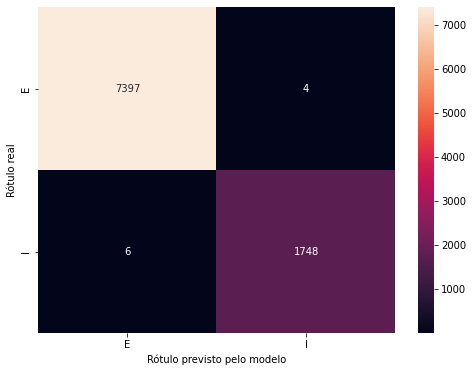

              precision    recall  f1-score   support

           E   0.999190  0.999460  0.999325      7401
           I   0.997717  0.996579  0.997148      1754

    accuracy                       0.998908      9155
   macro avg   0.998453  0.998019  0.998236      9155
weighted avg   0.998907  0.998908  0.998907      9155

Coeficiente de Matthew: 0.996473


In [23]:
# Aplicação do modelo de árvore de decisão
train_model(tree.DecisionTreeClassifier(), x_train, y_train, x_valid, y_valid)

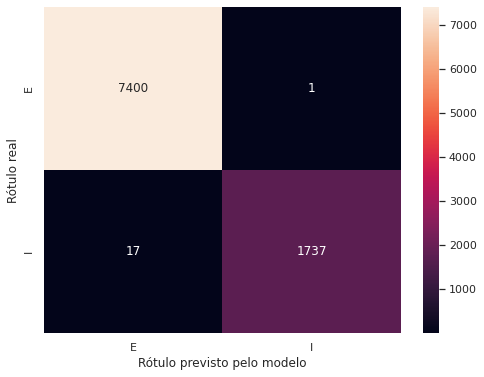

              precision    recall  f1-score   support

           E   0.997708  0.999865  0.998785      7401
           I   0.999425  0.990308  0.994845      1754

    accuracy                       0.998034      9155
   macro avg   0.998566  0.995086  0.996815      9155
weighted avg   0.998037  0.998034  0.998030      9155

Coeficiente de Matthew: 0.993647


In [ ]:
# Aplicação do modelo Random Forest
train_model(RandomForestClassifier(), x_train, y_train, x_valid, y_valid)